**Note:** as this was a previous point in the project, some definitions and statements may not be accurate, or may have changed later.   
Make sure to refer to the files labeled as `ME536_Project_v4` for the latest changes.

#To-Do List
Keep track of project progress in this list

##Completed Things
- **Image Processing** - ~Prepare a feature class~ 
  - ~Load RegionProps into instances as attributes~
  - ~Load the zero-background feature snapshots as an attribute~
  - ~Load the label of region as an attribute~ 

- **Image Processing** - ~Prepare a function (or method of feature class)~
  - ~Iteratively go through all labeled regions~  
  - ~Generate feature attributes~  

- **Image Processing** - Prepare live cam feed
  - Option 1: Take photos at intervals (once every few seconds)
  - Option 2: Capture live video, but process it at intervals
  - Option 3: Capture live video and process it live(?) (maybe at a specified fps)  

  *Maybe set up camera feed on a Colab Notebook to do it on Colab*

- **Data Analysis**, **Clustering** - Prepare line fitting functionality
  - **Data Analysis** - Review SVD, CUR, PCA as required
  - Define 4 principal axes (vertical, horizontal, left diagonal, right diagonal)
  - **Data Analysis** - Try fitting appropriate axes for objects in given orientations
  - **Data Clustering** - Option 1: Limit centroid distances in chain for clustering purposes
  - **Data Clustering** - Option 2: Maybe use a clustering algorithm like KMeans for centroid clustering

- **Artificial Neural Networks**

#Imports and Image/Video Feed

In [ ]:
# Core imports

#Image processing -- may use one or both
import skimage
#import cv2
#Python image library is convenient to open images
#from PIL import Image, ImageDraw, ImageFont

#Handling data
import numpy as np
#import scipy
from scipy import ndimage as ndi

#Imports from skimage
from skimage import measure
from skimage import filters
from skimage import morphology
from skimage import io
from skimage.color import rgb2gray
#from skimage.color import gray2rgb
from skimage.filters import threshold_otsu

import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px

#Imports from sklearn
#from sklearn.cluster import KMeans

In [ ]:
from google.colab import drive

In [ ]:
drive.mount("/content/gdrive")

Mounted at /content/gdrive


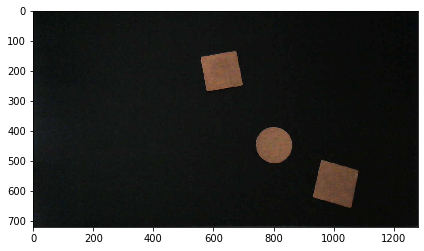

In [ ]:
#Using this tutorial > https://scipy-lectures.org/packages/scikit-image/auto_examples/plot_labels.html
#!ls "/content/gdrive/MyDrive"
#Mount drive, and read file -- has to be replaced with a camera feed later
test_image = io.imread("/content/gdrive/MyDrive/webcam_test.jpg")
io.imshow(test_image)

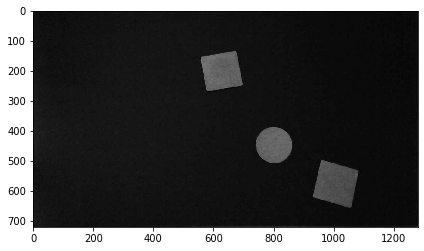

In [ ]:
#Load in the image, and get grayscale
im = test_image.copy()
gray = rgb2gray(im)
io.imshow(gray)

#Playground before function implementation

In [ ]:
io.imshow(im)

In [ ]:
#Binarization, using Otsu's thresholding method
thresh = threshold_otsu(gray)
binary = gray > thresh 
io.imshow(binary)

In [ ]:
#Salt and pepper noise is to be removed inside the objects
#Use erosion,dilation,opening,closing to remove noise exterior to the objects is necessary

fill_objects = binary.copy()

fill_objects = morphology.binary_erosion(fill_objects)
fill_objects = ndi.binary_fill_holes(fill_objects)
fill_objects = morphology.binary_closing(fill_objects)
fill_objects = morphology.binary_dilation(fill_objects)
io.imshow(fill_objects)

In [ ]:
#labels = measure.label(fill_objects)
labels = measure.label(fill_objects, background = 0)

plt.figure(figsize=(9, 3.5))
plt.subplot(131)
plt.imshow(fill_objects, cmap='gray')
plt.axis('off')
plt.subplot(132)
plt.imshow(labels, cmap='nipy_spectral')
plt.axis('off')
plt.subplot(133)
plt.imshow(labels, cmap='nipy_spectral')
plt.axis('off')

In [ ]:
print(labels.max()) #should be equal to the number of objects on the picture

In [ ]:
##PLAY AROUND WITH THIS IF FEATURES CANNOT BE PROPERLY FRAMED!
bound_ratio = 4

#Using connected component labeling tools of skimage
props = measure.regionprops(labels)

centroids = []
perimeters = []
areas = []
orientations = []
euler_numbers = []

#TODO FOR FUNCTION
#Iterate through 1 to len(props)!
##
label_pick = 1
##

centroid = props[label_pick-1].centroid
perimeter = props[label_pick-1].perimeter
area = props[label_pick-1].area
orientation = props[label_pick-1].orientation
euler_number = props[label_pick-1].euler_number #8-neighbors
#euler_number_4 = measure.euler_number(img_labels[label_pick-1], connectivity=4) #4-neighbors
#print(skimage.measure.regionprops.__doc__) #read here for more

compactness = (perimeter**2/area)/(4*np.pi) #defined in class

#Show the specified feature
#find label on label image, put it on the foreground, make the rest of the image the background
#plt.imshow(np.where((labels==label_pick),labels,0), cmap="nipy_spectral") 

#Get a trimmed off image
feature = np.zeros_like(labels)
feature = np.where((labels==label_pick),labels,0)
trimmed = feature.copy()

#initialize boundaries
bound_top = 0
bound_bot = feature.shape[0]
bound_left = 0
bound_right = feature.shape[1]

"""
#use zero row/cols -- not really a good idea
for row in range(feature.shape[0]):
  bound_top = 0
  if (feature[row,:]==0).all() == True:
    bound_top = row
  else:
    break

for row in range(feature.shape[0]-1,0,-1):
  bound_bot = feature.shape[0]-1
  if (feature[row,:]==0).all() == True:
    bound_bot = row
  else:  
    break

for col in range(feature.shape[1]):
  bound_left = 0
  if (feature[:,col]==0).all() == True:
    bound_left = col
  else:
    break

for col in range(feature.shape[0]-1,0,-1):
  bound_right = feature.shape[0]-1
  if (feature[:,col]==0).all() == True:
    bound_right = col
  else:
    break
#"""
#"""
#use bounded frames derived from centroid position, area, and perimeter data
#quite effective in bounding anything at all - details in the formulation below
bound = (area/perimeter)*bound_ratio
center = tuple([int(centroid[0]),int(centroid[1])])

if center[0]-bound > 0:
  bound_top = int(center[0]-bound)
else:
  bound_top = 0

if center[0]+bound < im.shape[0]:
  bound_bot = int(center[0]+bound)
else:
  bound_bot = im.shape[0]

if center[1]-bound > 0:
  bound_left = int(center[1]-bound)
else:
  bound_left = 0

if center[1]+bound < im.shape[1]:
  bound_right = int(center[1]+bound)
else:
  bound_right = im.shape[1]
#"""
trimmed = feature[bound_top:bound_bot,bound_left:bound_right]
#plt.imshow(trimmed, cmap="nipy_spectral")

im_trimmed = im[bound_top:bound_bot,bound_left:bound_right].copy()
im_flushed = im_trimmed.copy()

im_flushed[:,:,0] = np.where(trimmed==label_pick, im_trimmed[:,:,0], 0)
im_flushed[:,:,1] = np.where(trimmed==label_pick, im_trimmed[:,:,1], 0)
im_flushed[:,:,2] = np.where(trimmed==label_pick, im_trimmed[:,:,2], 0)

feature_color = np.zeros((1,3))

red_flushed = im_flushed[:,:,0]
green_flushed = im_flushed[:,:,1]
blue_flushed = im_flushed[:,:,2]

feature_color[:,0] = red_flushed[red_flushed.nonzero()].mean()
feature_color[:,1] = green_flushed[green_flushed.nonzero()].mean()
feature_color[:,2] = blue_flushed[blue_flushed.nonzero()].mean()

print(f"Feature Number: {label_pick}")
print(f"Averaged RGB values of feature: {feature_color}")
print(f"Centroid: {centroid}")
print(f"Perimeter: {perimeter}")
print(f"Area: {area}")
print(f"Orientation [Radians]: {orientation}")
print(f"Euler Number: {euler_number}") #blobs should yield a one I guess?
print(f"Compactness: {compactness}")
print(f"Top Left Corner: {(bound_top,bound_left)}")
print(f"Bottom Right Corner: {(bound_bot,bound_right)}")

#plt.imshow(np.where((labels==label_pick),labels,0), cmap="nipy_spectral")
#px.imshow(im)
#plt.imshow(trimmed, cmap="nipy_spectral")
#px.imshow(im_trimmed)
plt.imshow(im_flushed, cmap="nipy_spectral")

In [ ]:
px.imshow(im_flushed)

In [ ]:
#Explanation on why bound = (area/perimeter)*4
#where bound = side/2
#Note: only regular shapes will be used as features in the demo!

side = 10000
bound = side/2

circle_area = 0.25*np.pi*(side**2)
circle_perimeter = np.pi*side
circle_param = circle_area/circle_perimeter

square_area = side**2
square_perimeter = 4*side
square_param = square_area/square_perimeter

triangle_area = 0.4330127*side**2
triangle_perimeter = 3*side
triangle_param = triangle_area/triangle_perimeter

print(circle_param)
print(square_param)
print(triangle_param)

#safe to work with +-triangle_param*3.5~4 from centroid?
print(bound/triangle_param)
print(bound/square_param)

2499.9999999999995
2500.0
1443.3756666666666
3.4641016302755094
2.0


#Function definition for feature extraction and the Feature class

Earlier on in the implementation, a *bound ratio* definition was created to get variably sized bounding frames for the images. This works perfectly well for convex and regular objects, which were the initial picks to work with. However, a fixed size frame is equally as good most of the time. If it is necessary to work with variable frame sizes due to differing object sizes, this approach could be used to an extent.  
See the previous cell block: [**Playground before function implementation**](https://colab.research.google.com/drive/1wE1nRoSamTuLlpyhLZTSV_Yyk2pjGrNM#scrollTo=tN1C7qDLL3Gm&line=1&uniqifier=1) for the explanation of how this works.

In [ ]:
class Feature: 
  """
  The Feature class, to hold features, and the associated image (and later on,
  audio) of the feature vector.
  Some attributes may be used as neural network hyperparameters.
  Some attributes are required to find others (passed as None).
  Generate a Feature by first processing an image through FeatureExtractor.

  Dependencies: from skimage import io
                import numpy as np

  Attributes: Read the docstring of FeatureExtractor for more details.
              
              flushed_image:  The color image of the object bounded in a box,
                              with the background removed.
              
              vector: Feature vector obtained by the neural network.
              
              cluster: Clustering label, used to group objects that are near.
              
              sound: Sound file assigned to the feature. This could be an index
              pointing to the list of sound files, loaded along with training
              data for the neural network. The sound files will have new entries
              if the neural network recognizes the object as "new".
              
              effect_id: Sound effect assigned by the data analysis functions 
              to the feature. Could be a filter, reverb, reverse, etc. 
              Applicable to chords.
              Chords are objects clustered by their centroid distances.

  Methods:    imshow(): calls io.imshow() to view the flushed image.
  """
  def __init__(self, index, color, centroid, perimeter, area, orientation, 
               euler_number, compactness, corner_topleft, corner_botright, flushed_image):
    self.index = index
    self.color = color
    self.centroid = centroid
    self.perimeter = perimeter
    self.area = area
    self.orientation = orientation
    self.euler_number = euler_number
    self.compactness = compactness
    self.corner_topleft = corner_topleft
    self.corner_botright = corner_botright
    self.flushed_image = flushed_image

  def __str__(self):
    return (
        f'''Feature Number: {self.index},
        Averaged RGB values of feature: {self.color},
        Centroid: {self.centroid},
        Perimeter: {self.perimeter},
        Area: {self.area},
        Orientation [Radians]: {self.orientation},
        Euler Number: {self.euler_number},
        Compactness: {self.compactness},
        Top Left Corner: {self.corner_topleft},
        Bottom Right Corner: {self.corner_botright}'''
    )
  
  def imshow(self):
    #Returns the feature's "flushed" image, i.e. with zero-background
    #https://github.com/scikit-image/scikit-image/blob/master/skimage/io/_io.py#L139-L159
    return io.imshow(self.flushed_image)

In [ ]:
def FeatureExtractor(image, bound_ratio = 4, visualize=False, debugMode=False):
  
  """
  Extract from an image, the features on the foreground of the image and their
  attributes. 
  Requires a Feature class to function. 

  Dependencies: import skimage
                import numpy as np
                import scipy.ndimage as ndi
                import skimage.morphology as morphology
                from skimage.filters import threshold_otsu
                from skimage import io
                from skimage import measure
                import matplotlib.pyplot as plt
                from skimage.color import rgb2gray

  Note:
  Can be also used on grayscale images without failure, but the original image
  will be then a grayscale one, when the isolated image is shown; and the color 
  values will be for the grayscale image.

  Inputs: numpy.ndarray (3D RGB image, or 2D grayscale image)
          
          bound_ratio (float): Defines how large the bounding window will be. Explicitly
          defines the ratio of the feature's area to its circumference.
          Recommended value is 4, and the minimum possible value is 3.6. Going
          lower may cause clipping.

          visualize (bool): True - enable plots for the feature extraction 
          process, to debug in case additional features appear due to 
          inadequate filtering. Defaults to False.

          debugMode (bool): True - Enable debug outputs. Defaults to False.

  Outputs:  feature_idx (list, int) - List of feature label numbers

            colors (list, numpy.ndarray) - List of feature colors in RGB

            centroids (list, float) - List of feature centroid positions 
            on original image.

            perimeters (list, float) - List of feature perimeters
            
            areas (list, float) - List of feature areas
            
            orientations (list, float) - List of feature orientations. 
            The CCW angle with the positive horizontal axis is given in radians.
            
            euler_numbers (list, float) - List of feature Euler Numbers 
            (8-neighbors).
            
            TL_corners (list, tuple, int) - List of feature top left corner
            index positions, on original image. 
            Useful for bounding box generation.
            
            BR_corners (list, tuple, int) - List of feature bottom right corner
            index positions, on original image. 
            Useful for bounding box generation.
  """

  #Load in the image, and get grayscale
  im = image.copy()
  gray = rgb2gray(im)

  #Binarization, using Otsu's thresholding method
  thresh = threshold_otsu(gray)
  binary = gray > thresh 
  
  #Salt and pepper noise is to be removed inside the objects

  fill_objects = binary.copy()

  fill_objects = morphology.binary_erosion(fill_objects)
  fill_objects = ndi.binary_fill_holes(fill_objects)
  fill_objects = morphology.binary_closing(fill_objects)
  fill_objects = morphology.binary_dilation(fill_objects)
  
  labels = measure.label(fill_objects, background = 0)
  if debugMode == True:
    print(f"The number of features recognized:{labels.max()}") #should be equal to the number of objects on the picture

  #Using connected component labeling tools of skimage
  props = measure.regionprops(labels)
  
  features = []

  feature_idx = []
  colors = []
  centroids = []
  perimeters = []
  areas = []
  orientations = []
  euler_numbers = []
  compactnesses = []
  TL_corners = []
  BR_corners = []

  for label_pick in range(1,labels.max()+1):
    centroid = props[label_pick-1].centroid
    perimeter = props[label_pick-1].perimeter
    area = props[label_pick-1].area
    orientation = props[label_pick-1].orientation
    euler_number = props[label_pick-1].euler_number #8-neighbors
    compactness = (perimeter**2/area)/(4*np.pi) #defined in class

    #Get a trimmed off image
    feature = np.zeros_like(labels)
    feature = np.where((labels==label_pick),labels,0)
    trimmed = feature.copy()

    #initialize boundaries
    bound_top = 0
    bound_bot = feature.shape[0]
    bound_left = 0
    bound_right = feature.shape[1]

    #use bounded frames derived from centroid position, area, and perimeter data
    #quite effective in bounding anything at all - details in the formulation below
    bound = (area/perimeter)*bound_ratio
    center = tuple([int(centroid[0]),int(centroid[1])])

    if center[0]-bound > 0:
      bound_top = int(center[0]-bound)
    else:
      bound_top = 0

    if center[0]+bound < im.shape[0]:
      bound_bot = int(center[0]+bound)
    else:
      bound_bot = im.shape[0]

    if center[1]-bound > 0:
      bound_left = int(center[1]-bound)
    else:
      bound_left = 0

    if center[1]+bound < im.shape[1]:
      bound_right = int(center[1]+bound)
    else:
      bound_right = im.shape[1]

    trimmed = feature[bound_top:bound_bot,bound_left:bound_right]
    #plt.imshow(trimmed, cmap="nipy_spectral")

    im_trimmed = im[bound_top:bound_bot,bound_left:bound_right].copy()
    im_flushed = im_trimmed.copy()

    im_flushed[:,:,0] = np.where(trimmed==label_pick, im_trimmed[:,:,0], 0)
    im_flushed[:,:,1] = np.where(trimmed==label_pick, im_trimmed[:,:,1], 0)
    im_flushed[:,:,2] = np.where(trimmed==label_pick, im_trimmed[:,:,2], 0)

    feature_color = np.zeros((1,3))

    red_flushed = im_flushed[:,:,0]
    green_flushed = im_flushed[:,:,1]
    blue_flushed = im_flushed[:,:,2]

    feature_color[:,0] = red_flushed[red_flushed.nonzero()].mean()
    feature_color[:,1] = green_flushed[green_flushed.nonzero()].mean()
    feature_color[:,2] = blue_flushed[blue_flushed.nonzero()].mean()

    if debugMode == True:
      print(f"Feature Number: {label_pick}")
      print(f"Averaged RGB values of feature: {feature_color}")
      print(f"Centroid: {centroid}")
      print(f"Perimeter: {perimeter}")
      print(f"Area: {area}")
      print(f"Orientation [Radians]: {orientation}")
      print(f"Euler Number: {euler_number}")
      print(f"Compactness: {compactness}")
      print(f"Top Left Corner: {(bound_top,bound_left)}")
      print(f"Bottom Right Corner: {(bound_bot,bound_right)}")
    """
    if isClass == False:
      feature_idx.append(label_pick)
      colors.append(feature_color)
      centroids.append(centroid)
      perimeters.append(perimeter)
      areas.append(area)
      orientations.append(orientation)
      euler_numbers.append(euler_number)
      compactnesses.append(compactness)
      TL_corners.append((bound_top,bound_left))
      BR_corners.append((bound_bot,bound_right)) 
    
    if isClass == True:
    """
    features.append(Feature(label_pick,feature_color,centroid,perimeter,area,
                            orientation,euler_number,compactness,
                            (bound_top,bound_left),
                            (bound_bot,bound_right),im_flushed))


    if visualize == True:
      fig(plt.figure(figsize=(18, 7)))
      plt.subplot(151, title="Denoised Binary")
      plt.imshow(fill_objects, cmap='gray')
      plt.axis('off')
      plt.subplot(152, title= "All labels")
      plt.imshow(labels, cmap='nipy_spectral')
      plt.axis('off')
      plt.subplot(153, title= "Grayscale image")
      plt.imshow(gray, cmap='gray')
      plt.axis('off')
      plt.subplot(154, title= "Isolated image")
      plt.imshow(np.where((labels==label_pick),labels,0), cmap="nipy_spectral")
      plt.axis('off')
      plt.subplot(155, title= f"Flushed feature image: {label_pick}")
      plt.imshow(im_flushed, cmap="nipy_spectral")
      plt.axis('off')
  """
  if isClass == False:
    return (feature_idx, colors, centroids, perimeters, areas, orientations, 
          euler_numbers, compactnesses, TL_corners, BR_corners)
  elif isClass == True:
  """
  return features

## Playground for Feature Extraction

In [ ]:
features = FeatureExtractor(im) #quite snappy, and quite neat!

Feature Number: 3,
        Averaged RGB values of feature: [[106.5400915   73.5848784   54.51492897]],
        Centroid: (576.3470984830243, 1006.3752708885144),
        Perimeter: 539.2619766708755,
        Area: 16612,
        Orientation [Radians]: 0.7597760177027083,
        Euler Number: 1,
        Compactness: 1.3930535524933425,
        Top Left Corner: (452, 882),
        Bottom Right Corner: (699, 1129)


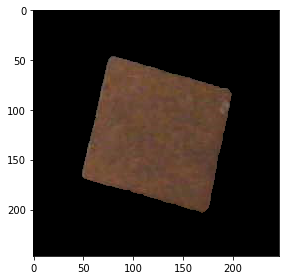

In [ ]:
#added a method call - Feature.imshow() which calls io.imshow,
#on the flushed image.

print(features[2])
features[2].imshow()

#Singular Value Decomposition to Fit a Singular Vector Between the Centroids

In [ ]:
centroids = np.zeros((len(features),2))
for idx in range(len(features)):
  centroids[idx][0] = features[idx].centroid[0]
  centroids[idx][1] = features[idx].centroid[1]

u, s, vh = np.linalg.svd(centroids, full_matrices=True)

#print(u)
#print(s)
print(vh)

ang=-np.arctan2(vh[0][0],vh[0][1])*180/np.pi
print(ang)

principals = [0,45,90,135,180,225,270,315,360]
print(principals[(np.abs(principals-ang)).argmin()])

[[-0.4643618  -0.88564559]
 [-0.88564559  0.4643618 ]]
152.33107331133553
135


In [ ]:
print(centroids)

[[ 202.4453048   626.43242292]
 [ 447.51029489  800.82236957]
 [ 576.34709848 1006.37527089]]


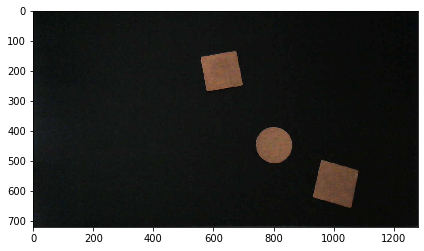

In [ ]:
io.imshow(test_image)